In [ ]:
%pip install scikit-learn-extra

     |████████████████████████████████| 624kB 4.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=339566 sha256=e8af68807767ab7ebd11b2941d02ce203b1cb130af996d0166a86ad1e6e32e99
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
import tensorflow as tf
import os
import os.path
import random
import shutil
import hashlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
import torch.utils.data as data
from torch.utils.model_zoo import tqdm
import tarfile
import zipfile
from torch import Tensor
from torchvision import datasets
from torchvision.datasets import SBDataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from tqdm.auto import tqdm
from collections import OrderedDict
from typing import Any, List, Tuple, Optional, Callable, Dict, TypeVar, Iterable
from vision import *
from utils import *

random.seed(0)

**Steps to do:**

*   Preprocessing
  *   Ignore images with dimension lower than 300x300
  *   For images with multiple labels, pick one and let the others be part of the background
  *   Take a 300x300 crop by resampling crops until the complete object instance is inside the crop
  *   Upscale image to 480x480
  *   Use k-mediods to generate random number of foreground & background clicks
  *   Generate interaction maps
*   Model
  *   DenseNet-121 Encoder
  *   Decoder from BRS paper
  *   Add ASPP module between Encoder & Decoder
  *   Add Semantic Supervision block to Encoder during pretraining
  *   Add LIP for pooling



In [ ]:
def PIL_to_tensor(img, target):
  return transforms.ToTensor()(img), transforms.ToTensor()(target)

In [ ]:
def download_extract(url: str, root: str, filename: str, md5: str) -> None:
    download_url(url, root, filename, md5)
    with tarfile.open(os.path.join(root, filename), "r") as tar:
        tar.extractall(path=root)

In [ ]:
class CustomSBDataset(VisionDataset):
    """`Semantic Boundaries Dataset <http://home.bharathh.info/pubs/codes/SBD/download.html>`_

    Args:
        root (string): Root directory of the Semantic Boundaries Dataset
        image_set (string, optional): Select the image_set to use, ``train``, ``val`` or ``train_noval``.
            Image set ``train_noval`` excludes VOC 2012 val images.
        mode (string, optional): Select target type. Possible values 'boundaries' or 'segmentation'.
            In case of 'boundaries', the target is an array of shape `[num_classes, H, W]`,
            where `num_classes=20`.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version. Input sample is PIL image and target is a numpy array
            if `mode='boundaries'` or PIL image if `mode='segmentation'`.
    """

    url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
    md5 = "82b4d87ceb2ed10f6038a1cba92111cb"
    filename = "benchmark.tgz"

    voc_train_url = "http://home.bharathh.info/pubs/codes/SBD/train_noval.txt"
    voc_split_filename = "train_noval.txt"
    voc_split_md5 = "79bff800c5f0b1ec6b21080a3c066722"

    def __init__(
            self,
            root: str,
            image_set: str = "train",
            mode: str = "segmentation",
            download: bool = False,
            img_filter_size = 200,
            transforms: Optional[Callable] = None,
    ) -> None:

        try:
            from scipy.io import loadmat
            self._loadmat = loadmat
        except ImportError:
            raise RuntimeError("Scipy is not found. This dataset needs to have scipy installed: "
                               "pip install scipy")

        super(CustomSBDataset, self).__init__(root, transforms)
        self.image_set = verify_str_arg(image_set, "image_set",
                                        ("train", "val", "train_noval"))
        self.mode = verify_str_arg(mode, "mode", ("segmentation", "boundaries"))
        self.num_classes = 20
        self.img_filter_size = img_filter_size

        sbd_root = self.root
        image_dir = os.path.join(sbd_root, 'img')
        mask_dir = os.path.join(sbd_root, 'inst')

        if download:
            self.download_dataset(sbd_root)

        if not os.path.isdir(sbd_root):
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')
            
        self.load_filenames(sbd_root, image_dir, mask_dir, image_set)

        self._get_target = self._get_segmentation_target \
            if self.mode == "segmentation" else self._get_boundaries_target

        #self.filter_images()

    def _get_segmentation_target(self, filepath: str) -> Image.Image:
        mat = self._loadmat(filepath)
        return Image.fromarray(mat['GTinst'][0]['Segmentation'][0])

    def _get_boundaries_target(self, filepath: str) -> np.ndarray:
        mat = self._loadmat(filepath)
        return np.concatenate([np.expand_dims(mat['GTinst'][0]['Boundaries'][0][i][0].toarray(), axis=0)
                               for i in range(self.num_classes)], axis=0)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        img = Image.open(self.images[index]).convert('RGB')
        target = self._get_target(self.masks[index])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        img = transforms.ToTensor()(img)
        target = (transforms.ToTensor()(target)*255)
        target = self.naive_ignore_multiple_object_instances(target)
        img, target = self.center_crop(img, target)
        img = transforms.Resize((480, 480))(img)
        target = transforms.Resize((480, 480))(target)

        return img, target

    def __len__(self) -> int:
        return len(self.images)

    def extra_repr(self) -> str:
        lines = ["Image set: {image_set}", "Mode: {mode}"]
        return '\n'.join(lines).format(**self.__dict__)

    def download_dataset(self, sbd_root) -> None:
        download_extract(self.url, self.root, self.filename, self.md5)
        extracted_ds_root = os.path.join(self.root, "benchmark_RELEASE", "dataset")

        for f in ["cls", "img", "inst", "train.txt", "val.txt"]:
            old_path = os.path.join(extracted_ds_root, f)
            shutil.move(old_path, sbd_root)
        download_url(self.voc_train_url, sbd_root, self.voc_split_filename,
                      self.voc_split_md5)
        
    def load_filenames(self, sbd_root, image_dir, mask_dir, image_set) -> None:
        split_f = os.path.join(sbd_root, image_set.rstrip('\n') + '.txt')

        with open(os.path.join(split_f), "r") as fh:
            file_names = [x.strip() for x in fh.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.masks = [os.path.join(mask_dir, x + ".mat") for x in file_names]
        assert (len(self.images) == len(self.masks))
        
    # Remove images with both height and width lower than img_filter_size
    def filter_images(self):
        img_to_remove = set()
        for i in range(len(self.images)):
            img = Image.open(self.images[i])
            width, height = img.size
            if width < self.img_filter_size or height < self.img_filter_size:
                img_to_remove.add(i)

        self.images = [img for index, img in enumerate(self.images) if index not in img_to_remove]
        self.masks = [mask for index, mask in enumerate(self.masks) if index not in img_to_remove]

    # For targets that have multiple object instances, pick label 1 as foreground and let the others be part of the background
    def naive_ignore_multiple_object_instances(self, target):
        cond = torch.eq(target, torch.ones_like(target))
        target = torch.where(cond, target, torch.zeros_like(target))
        return target

    # Apply CenterCrop to image to make it a square based on its smaller dimension
    def center_crop(self, image, target):
      min_len = min(image.shape[1], image.shape[2])
      image = transforms.CenterCrop(min_len)(image)
      target = transforms.CenterCrop(min_len)(target)
      return image, target

    # Apply Random Crop on Image & Target while keeping most of the object instance inside the crop
    def random_crop(self, image, target):
      left = -1
      right = -1
      top = -1
      bottom = -1

      # Find the extreme points of the object instance in the target
      res = torch.nonzero(target[0])
      values, indices = torch.min(res, 0)
      top = values[0].item()
      left = values[1].item()
      values, indices = torch.max(res, 0)
      bottom = values[0].item()
      right = values[1].item()

      # Calculate range to sample top left crop point from
      if right - left >= self.img_filter_size:
        x_min = (right - left)//2
        x_max = (right - left)//2
      else:
        x_min = min(0, right - self.img_filter_size)
        x_max = left

      if bottom - top >= self.img_filter_size:
        y_min = (bottom - top)//2
        y_max = (bottom - top)//2
      else:
        y_min = min(0, bottom - self.img_filter_size)
        y_max = top

      # Sample top left crop point
      x = random.randint(x_min, x_max)
      y = random.randint(y_min, y_max)

      # Apply same random crop to both image and target
      image = transforms.functional.crop(image, y, x, self.img_filter_size, self.img_filter_size)
      target = transforms.functional.crop(target, y, x, self.img_filter_size, self.img_filter_size)

      return image, target

In [ ]:
sbd = CustomSBDataset(root=".", image_set="train", mode="segmentation", download=False)

In [ ]:
img, target = sbd.__getitem__(0)
print(img.shape, target.shape)


torch.Size([3, 480, 480]) torch.Size([1, 480, 480])


In [ ]:
# Sample user clicks using target
def gen_clicks(target):
  num_pos = random.randint(1, 10)
  num_neg = random.randint(0, 10)

  pos_clicks = gen_pos_clicks(target, num_pos)
  neg_clicks = gen_neg_clicks(target, num_neg)

  return pos_clicks, neg_clicks

# Generate n +ve clicks using k-mediods on all points part of object mask
def gen_pos_clicks(target, n):
  points = torch.nonzero(target[0])
  kmediods = KMedoids(n)
  kmediods.fit(points.numpy())
  pos_clicks = torch.tensor(kmediods.cluster_centers_)
  return pos_clicks

# Generate n -ve clicks
def gen_neg_clicks(target, n):

  return None

In [ ]:
# Import SBDataset to DataLoader
batch_size = 64

transform = transforms.Compose([
  transforms.ToTensor(),
])

dataloader = DataLoader(
    SBDataset(
        root=".",
        image_set="train",
        mode="segmentation",
        download=False,
        transforms=PIL_to_tensor
    ),
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
sbd_val = SBDataset(root=".", image_set="val", mode="segmentation", download=False, transforms=PIL_to_tensor)

In [ ]:
print(sbd.__len__())
print(sbd_val.__len__())

8498
2857


In [ ]:
dataset = sbd

max_h = 0
max_w = 0
min_h = 500
min_w = 500
c_200 = 0
c_240 = 0
c_260 = 0
c_280 = 0
c_300 = 0
c_310 = 0
c_320 = 0
c_330 = 0
c_340 = 0
c_350 = 0
c_360 = 0
square_img = 0

for i in range(dataset.__len__()):
  img, target = dataset.__getitem__(i)

  if img.size[1] > max_h:
    max_h = img.size[1]
  if img.size[1] < min_h:
    min_h = img.size[1]
  if img.size[0] > max_w:
    max_w = img.size[0]
  if img.size[0] < min_w:
    min_w = img.size[0]
  
  if img.size[1] > 200 and img.size[0] > 200:
    c_200 += 1
  if img.size[1] > 240 and img.size[0] > 240:
    c_240 += 1
  if img.size[1] > 260 and img.size[0] > 260:
    c_260 += 1
  if img.size[1] > 280 and img.size[0] > 280:
    c_280 += 1
  if img.size[1] > 300 and img.size[0] > 300:
    c_300 += 1
  if img.size[1] > 310 and img.size[0] > 310:
    c_310 += 1
  if img.size[1] > 320 and img.size[0] > 320:
    c_320 += 1
  if img.size[1] > 330 and img.size[0] > 330:
    c_330 += 1
  if img.size[1] > 340 and img.size[0] > 340:
    c_340 += 1
  if img.size[1] > 350 and img.size[0] > 350:
    c_350 += 1
  if img.size[1] > 360 and img.size[0] > 360:
    c_360 += 1

  if img.size[1] == img.size[0]:
    square_img += 1

print("Max Height & Width:", max_h, max_w)
print("Min Height & Width:", min_h, min_w)
print("Images over 200x200:", c_200, (c_200*100)/dataset.__len__())
print("Images over 240x240:", c_240, (c_240*100)/dataset.__len__())
print("Images over 260x260:", c_260, (c_260*100)/dataset.__len__())
print("Images over 280x280:", c_280, (c_280*100)/dataset.__len__())
print("Images over 300x300:", c_300, (c_300*100)/dataset.__len__())
print("Images over 310x310:", c_310, (c_310*100)/dataset.__len__())
print("Images over 320x320:", c_320, (c_320*100)/dataset.__len__())
print("Images over 330x330:", c_330, (c_330*100)/dataset.__len__())
print("Images over 340x340:", c_340, (c_340*100)/dataset.__len__())
print("Images over 350x350:", c_350, (c_350*100)/dataset.__len__())
print("Images over 360x360:", c_360, (c_360*100)/dataset.__len__())
print("Square Images:", square_img, (square_img*100)/dataset.__len__())

torch.Size([3, 200, 200]) torch.Size([1, 200, 200])


TypeError: ignored

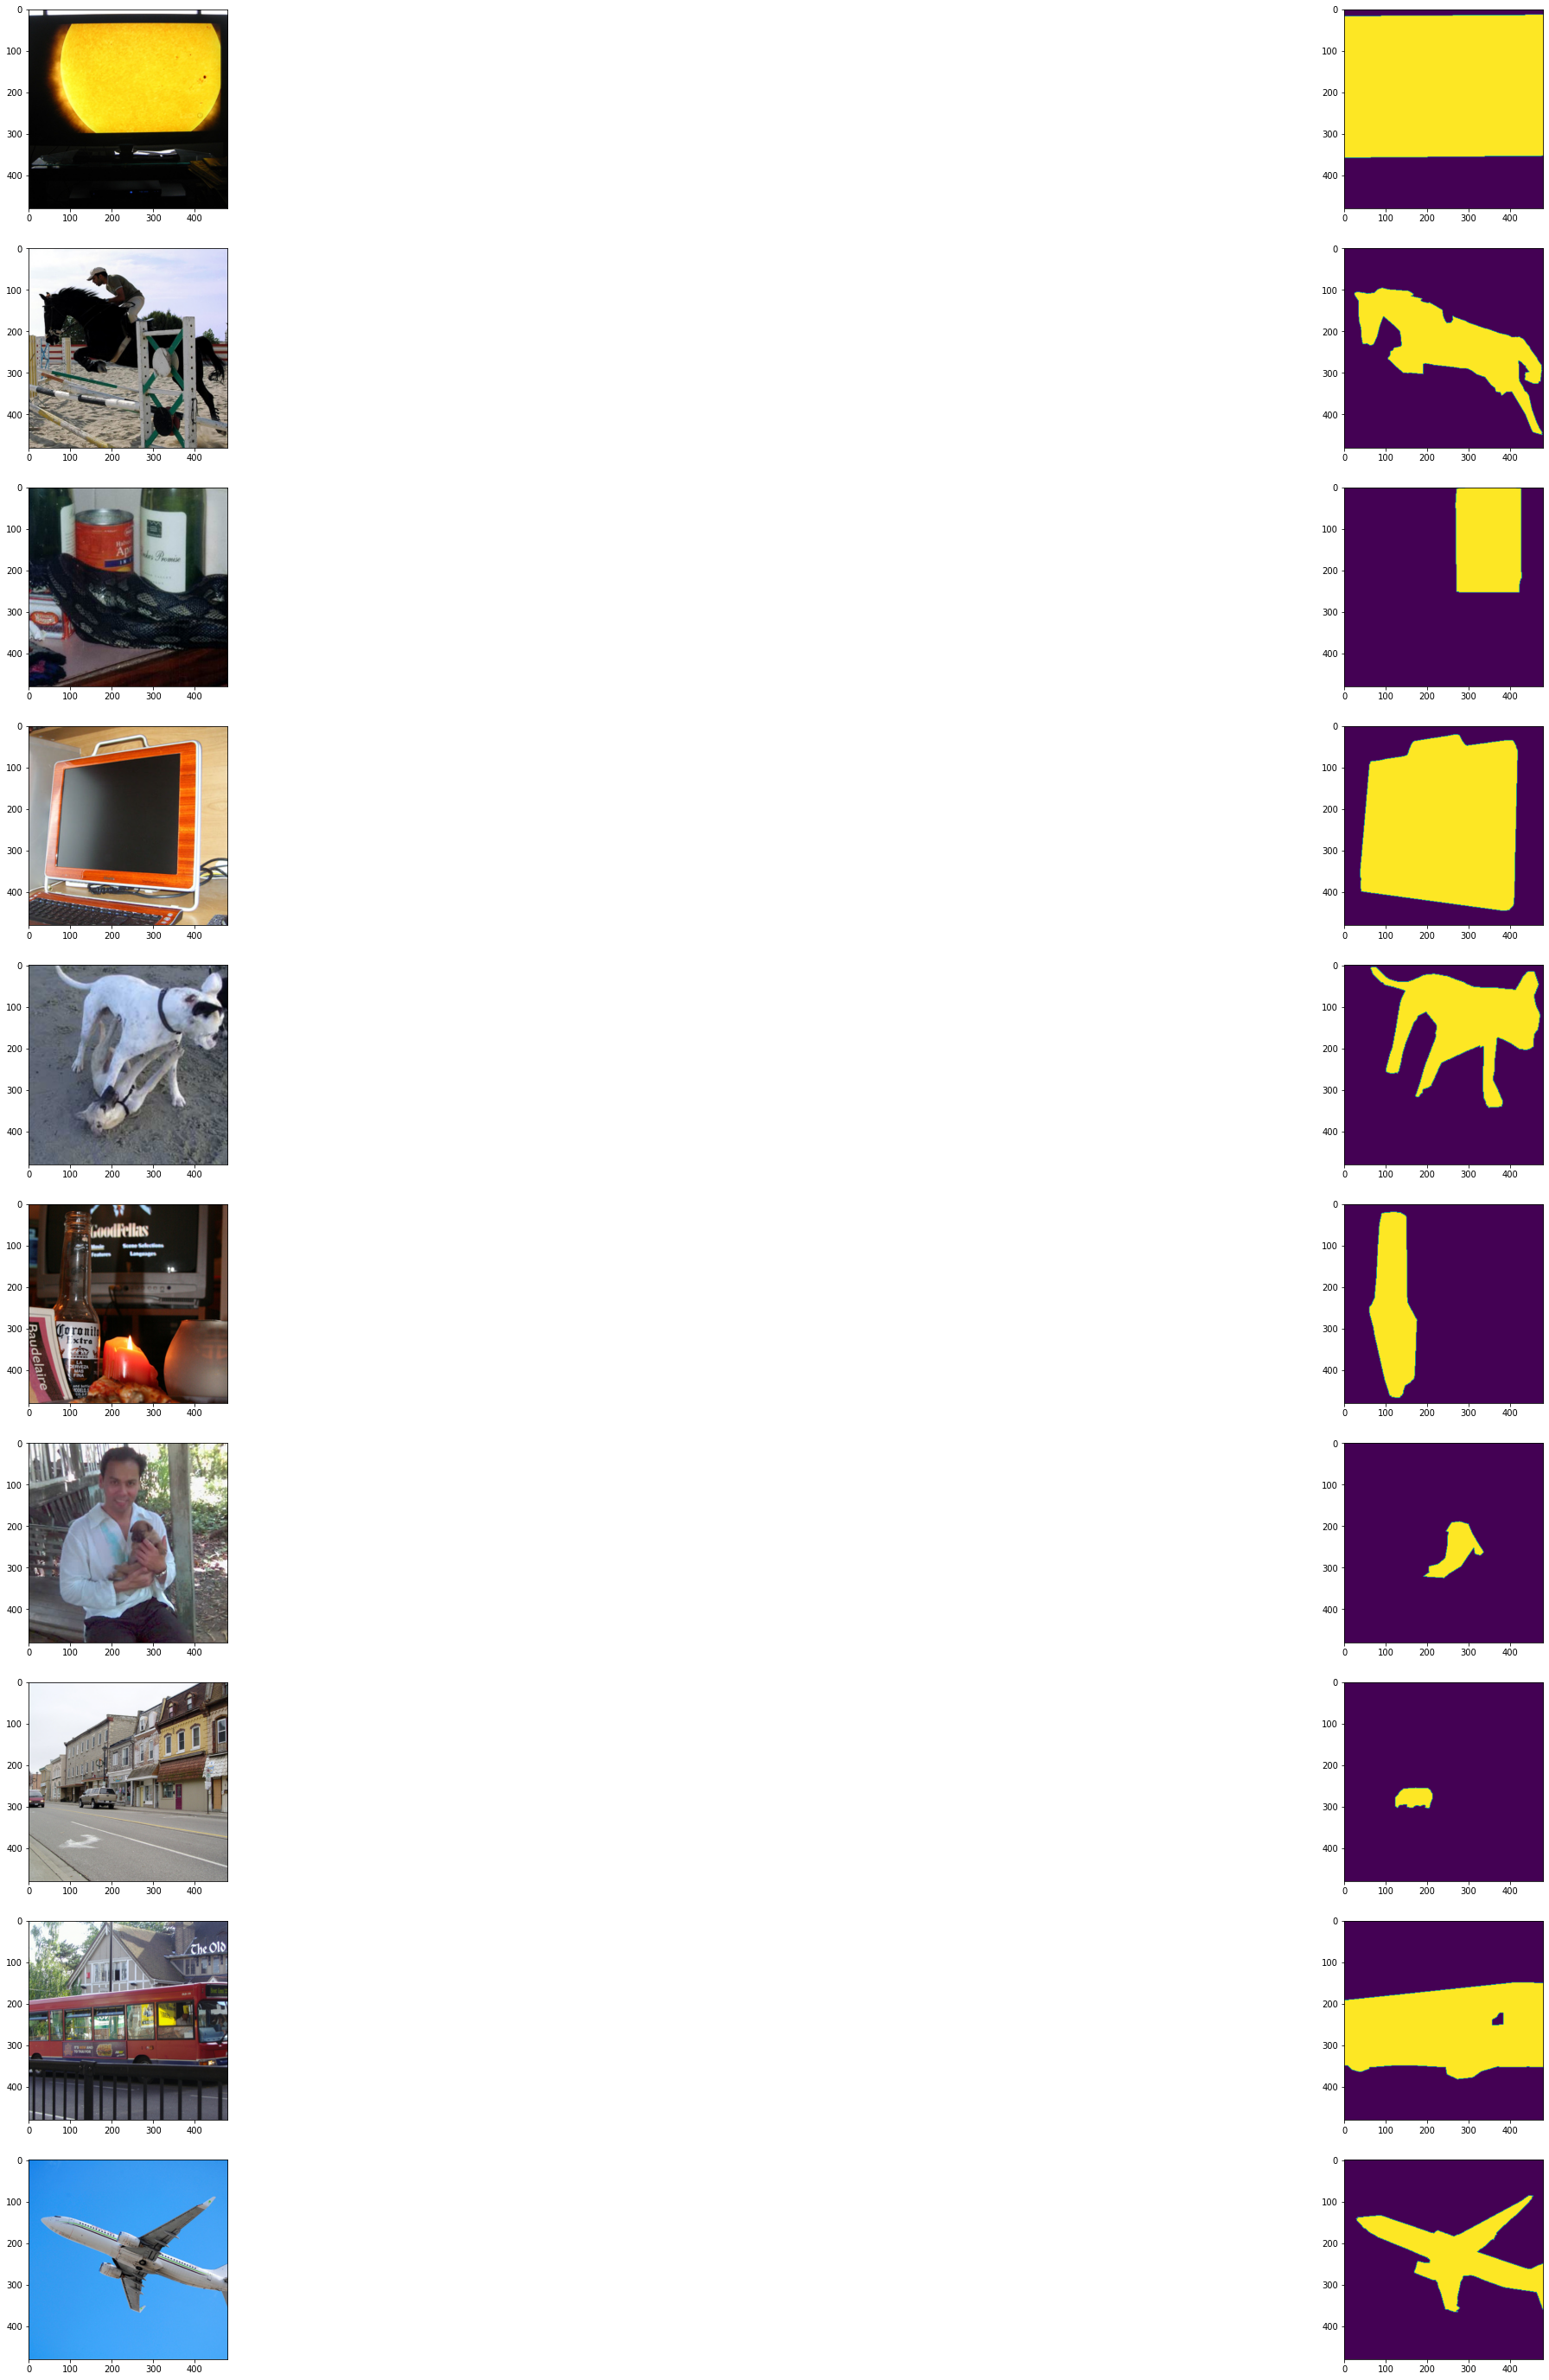

In [ ]:
fig,axes = plt.subplots(nrows = 10, ncols = 2, figsize=(50,50))

for i in range(10):
    img, target = sbd.__getitem__(i)
    
    axes[i,0].imshow(transforms.ToPILImage()(img))
    axes[i,1].imshow(transforms.ToPILImage()(target))

plt.show()

In [ ]:
"""
DenseNet Encoder Network
"""

class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    """Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


def _load_state_dict(model: nn.Module, model_url: str, progress: bool) -> None:
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)